In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_womens_first_round.csv')
print(df.shape)
df.head()

(224, 49)


,game_id,year,round,region,high_team_id,low_team_id,win,ppg,opp_ppg,net_ppg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
0,20171101,2017,First Round,East,2017 Connecticut,2017 Albany,1,23.1000,-10.8000,30.6000,...,0.0810,0.0500,0.0400,0.0900,-0.1170,-0.0110,-0.1800,-0.0480,-0.0510,-0.0290
1,20171108,2017,First Round,East,2017 Syracuse,2017 Iowa St.,1,9.9000,-6.4000,6.3000,...,-0.0440,0.0160,0.0430,0.0270,0.0800,0.1030,-0.4700,-0.0020,0.0000,0.0100
2,20171106,2017,First Round,East,2017 Texas A&M,2017 Penn,1,16.3000,2.8000,-2.3000,...,-0.0610,0.0070,0.0940,0.0880,-0.0590,0.0220,-0.1900,-0.0120,-0.0700,0.0500
3,20171104,2017,First Round,East,2017 UCLA,2017 Boise St.,1,10.4000,-4.1000,6.2000,...,-0.0370,0.0430,0.0120,0.0320,-0.0240,0.0350,-0.2900,-0.0220,-0.0270,-0.0070
4,20171103,2017,First Round,East,2017 West Virginia,2017 Elon,1,14.6000,-7.4000,0.9000,...,0.0030,0.0120,0.0230,0.0120,-0.0510,0.0170,-0.2400,0.0000,-0.0320,-0.0140


In [2]:
df['win'].value_counts(normalize=True)

1   0.8348
0   0.1652
Name: win, dtype: float64

In [3]:
df.columns

Index(['game_id', 'year', 'round', 'region', 'high_team_id', 'low_team_id',
       'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%'],
      dtype='object')

In [4]:
eda_df = df[[
    'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%']]

In [5]:
# Split dataset into a train and test set
X = eda_df.drop('win', axis=1)
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(156, 43)
(68, 43)


### I. Numerical Tests

In [6]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

ppg            18.7500
opp_ppg        16.7100
net_ppg        18.1900
off_rtg        15.0500
def_rtg        16.2800
net_rtg        17.3300
pace           11.0600
hhs_net_rtg    33.5600
hhs_def_rtg    17.7800
rpi            40.5500
ppp            14.1600
ppsa           12.0300
efg%           11.9600
ftr            15.8400
3pr            23.3200
%pts_ft        19.4700
trb%           11.4400
ast_tov        14.2600
stl%           15.1600
pf%            10.8800
pppd           18.1300
efgd%          10.5500
ftrd           15.0200
%pts_3pd       16.1200
tovd%          17.0900
opp_ast_tov    24.4300
win           100.0000
Name: win, dtype: float64


In [7]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,ppg,5.6142,0.0191,0.0207
1,opp_ppg,4.4246,0.0371,0.0000
2,net_ppg,5.2669,0.0231,0.0342
3,off_rtg,3.5685,0.0608,0.0339
4,def_rtg,4.1950,0.0422,0.0410
5,net_rtg,4.7696,0.0305,0.0322
6,pace,1.9071,0.1693,0.0000
7,hhs_net_rtg,19.5501,0.0000,0.0986
8,hhs_off_rtg,0.2798,0.5976,0.0000
9,hhs_def_rtg,5.0298,0.0263,0.0000


In [8]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
7,hhs_net_rtg,19.5501,0.0000,0.0986
10,rpi,30.3087,0.0000,0.1275
14,ftr,3.9633,0.0483,0.0596
16,%pts_ft,6.0651,0.0149,0.1133
25,stl%,3.6203,0.0589,0.0568
35,%pts_3pd,4.1096,0.0444,0.0574


In [9]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,ppg,5.6142,0.0191,0.0207
1,opp_ppg,4.4246,0.0371,0.0000
2,net_ppg,5.2669,0.0231,0.0342
4,def_rtg,4.1950,0.0422,0.0410
5,net_rtg,4.7696,0.0305,0.0322
7,hhs_net_rtg,19.5501,0.0000,0.0986
9,hhs_def_rtg,5.0298,0.0263,0.0000
10,rpi,30.3087,0.0000,0.1275
14,ftr,3.9633,0.0483,0.0596
15,3pr,8.8551,0.0034,0.0364


In [10]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,ppg,5.6142,0.0191,0.0207
2,net_ppg,5.2669,0.0231,0.0342
7,hhs_net_rtg,19.5501,0.0000,0.0986
9,hhs_def_rtg,5.0298,0.0263,0.0000
10,rpi,30.3087,0.0000,0.1275
15,3pr,8.8551,0.0034,0.0364
16,%pts_ft,6.0651,0.0149,0.1133
28,pppd,5.2342,0.0235,0.0475
38,opp_ast_tov,9.7759,0.0021,0.0229


### II. Wrapper Methods

In [11]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [12]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [13]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 42
selected features: 14
features with coefficients shrank to zero: 28


In [14]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.91
Lasso Regression F1 Score (Test): 0.90


In [15]:
selected_feat

Index(['opp_ppg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', '3pr', '%pts_ft',
       'trb%', 'stl%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd', '%pts_3pd',
       'opp_ast_tov'],
      dtype='object')

In [16]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [17]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [18]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['def_rtg', 'rpi', 'ppp', 'ppsa', 'orb%', 'pppd', 'opp_ppsa',
       'ftrd', '%pts_3pd', 'opp_blk%'], dtype=object)

In [19]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9844274809160305
Test set
Random Forests roc-auc: 0.8422619047619048


In [20]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9920610687022902
Test set
Random Forests roc-auc: 0.8273809523809524


In [21]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.47172619047619047,
 0.4568452380952381,
 0.634672619047619,
 0.5066964285714286,
 0.46279761904761896,
 0.5401785714285714,
 0.5290178571428572,
 0.5803571428571428,
 0.41145833333333337,
 0.49255952380952384,
 0.8653273809523809,
 0.6168154761904762,
 0.6138392857142857,
 0.44717261904761896,
 0.48809523809523814,
 0.5565476190476191,
 0.39508928571428575,
 0.4933035714285714,
 0.45386904761904756,
 0.5706845238095238,
 0.5104166666666666,
 0.5290178571428571,
 0.4107142857142857,
 0.4620535714285714,
 0.5505952380952381,
 0.5825892857142856,
 0.5178571428571429,
 0.6242559523809524,
 0.484375,
 0.47098214285714285,
 0.46949404761904756,
 0.5714285714285714,
 0.5267857142857143,
 0.48511904761904767,
 0.4650297619047619,
 0.4084821428571429,
 0.5491071428571428,
 0.390625,
 0.5528273809523809,
 0.43377976190476186,
 0.5401785714285714,
 0.421875]

Text(0, 0.5, 'roc-auc')

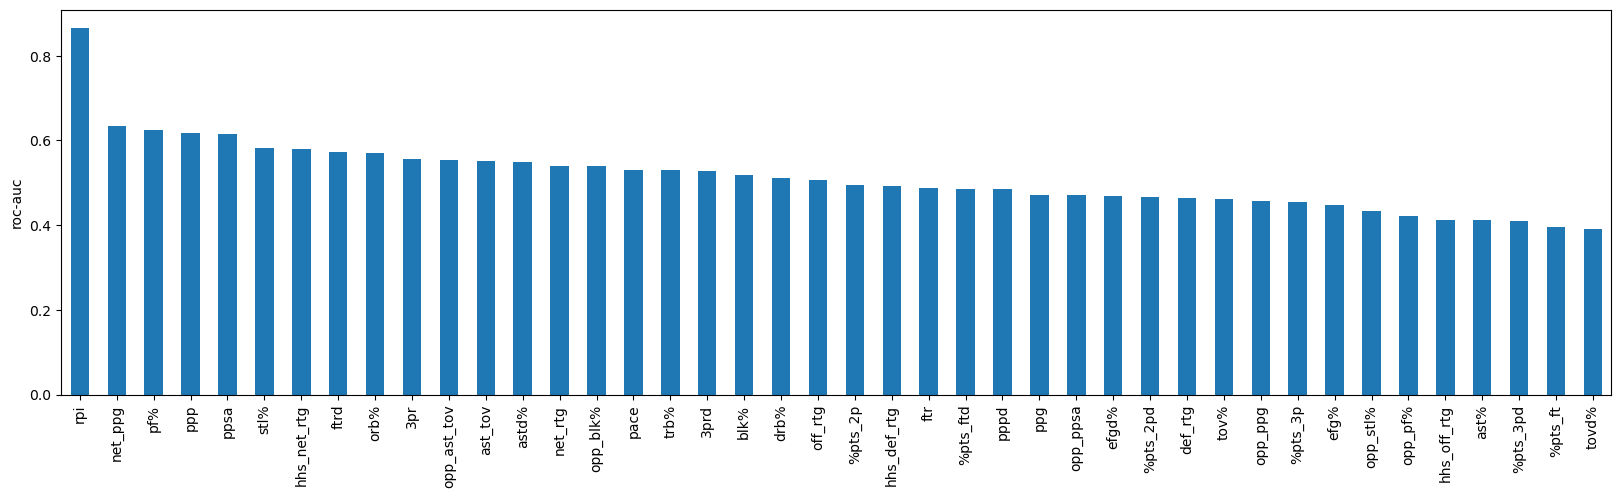

In [22]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [23]:
len(roc_values[roc_values > 0.6])

5

In [24]:
roc_values[roc_values > 0.6]

net_ppg   0.6347
rpi       0.8653
ppp       0.6168
ppsa      0.6138
pf%       0.6243
dtype: float64

In [25]:
roc_values[roc_values > 0.55]

net_ppg       0.6347
hhs_net_rtg   0.5804
rpi           0.8653
ppp           0.6168
ppsa          0.6138
3pr           0.5565
orb%          0.5707
ast_tov       0.5506
stl%          0.5826
pf%           0.6243
ftrd          0.5714
opp_ast_tov   0.5528
dtype: float64

In [45]:
X_train_scaled2 = X_train_scaled[[
 'rpi',
 'net_ppg',
 'ppp',
 'pf%',
 'hhs_net_rtg',
 'orb%',
 'stl%',
 'ftrd',
 '3pr',
 '%pts_3pd'
]]

X_test_scaled2 = X_test_scaled[[
 'rpi',
 'net_ppg',
 'ppp',
 'pf%',
 'hhs_net_rtg',
 'orb%',
 'stl%',
 'ftrd',
 '3pr',
 '%pts_3pd'
]]

In [46]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.1}


In [47]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [48]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.2863071185322547


In [49]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.95
F1 Score on Test Data: 0.89


<Figure size 1000x600 with 0 Axes>

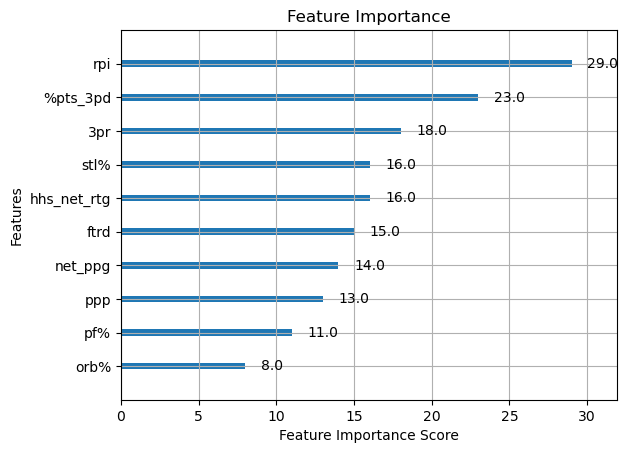

In [50]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()
